In [1]:
import sys
try:
    import pandas as pd
except ImportError as e:
    print("pandas is required for this example. Please install with conda or pip  and then try again.")
    sys.exit()

import numpy as np
import sklearn
from sklearn import ensemble
import kmapper as km
from kmapper.plotlyviz import *

import warnings
warnings.filterwarnings("ignore")

In [2]:
import plotly.graph_objs as go
from ipywidgets import (HBox, VBox)

In [3]:
from sklearn import cluster

In [68]:
# Data - the Wisconsin Breast Cancer Dataset
# https://www.kaggle.com/uciml/breast-cancer-wisconsin-data
df = pd.read_csv("../data/breast-cancer.csv")
feature_names = [c for c in df.columns if c not in ["id", "diagnosis"]]
df["diagnosis"] = df["diagnosis"].apply(lambda x: 1 if x == "M" else 0)
X = np.array(df[feature_names].fillna(0))
y = np.array(df["diagnosis"])

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 569 entries, 0 to 568
Data columns (total 33 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   id                       569 non-null    int64  
 1   diagnosis                569 non-null    int64  
 2   radius_mean              569 non-null    float64
 3   texture_mean             569 non-null    float64
 4   perimeter_mean           569 non-null    float64
 5   area_mean                569 non-null    float64
 6   smoothness_mean          569 non-null    float64
 7   compactness_mean         569 non-null    float64
 8   concavity_mean           569 non-null    float64
 9   concave points_mean      569 non-null    float64
 10  symmetry_mean            569 non-null    float64
 11  fractal_dimension_mean   569 non-null    float64
 12  radius_se                569 non-null    float64
 13  texture_se               569 non-null    float64
 14  perimeter_se             5

In [6]:
print(X.shape)
print(y.shape)

(569, 31)
(569,)


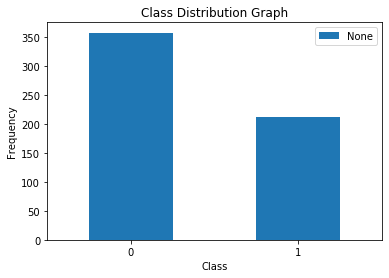

In [7]:
#plotting class distribution graph using a function
#importing saperate functions from pandas
from pandas import value_counts
import matplotlib.pyplot as plt

def class_distribution_graph():
    count_classes = value_counts(y, sort = True)
    count_classes.plot(kind = 'bar', rot = 0)
    plt.title("Class Distribution Graph")
    plt.xlabel("Class")
    plt.ylabel("Frequency")
    plt.legend()
    
#calling the function
class_distribution_graph()

In [8]:
#classifying normal and fraud label

benign = df[df["diagnosis"] == 0]
malignant = df[df["diagnosis"] == 1]

In [9]:
#printing the total numbers of fraud and normal transactions wit respect to its row

print(benign.shape, malignant.shape)

(357, 33) (212, 33)


In [10]:
#Description of both the transactions

benign.area_mean.describe()

count    357.000000
mean     462.790196
std      134.287118
min      143.500000
25%      378.200000
50%      458.400000
75%      551.100000
max      992.100000
Name: area_mean, dtype: float64

In [11]:
malignant.area_mean.describe()

count     212.000000
mean      978.376415
std       367.937978
min       361.600000
25%       705.300000
50%       932.000000
75%      1203.750000
max      2501.000000
Name: area_mean, dtype: float64

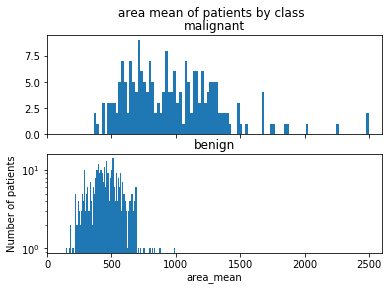

In [12]:
f, (ax1, ax2) = plt.subplots(2, 1, sharex=True)
f.suptitle(' area mean of patients by class')
bins = 100
ax1.hist(malignant.area_mean, bins = bins)
ax1.set_title('malignant')
ax2.hist(benign.area_mean, bins = bins)
ax2.set_title('benign')
plt.xlabel('area_mean')
plt.ylabel('Number of patients')
plt.xlim((0, 2600))
plt.yscale('log')
plt.show()

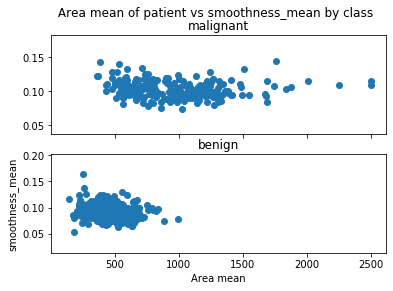

In [13]:
f, (ax1, ax2) = plt.subplots(2, 1, sharex=True)
f.suptitle(' Area mean of patient vs smoothness_mean by class')
ax1.scatter(malignant.area_mean, malignant.smoothness_mean)
ax1.set_title('malignant')
ax2.scatter(benign.area_mean, benign.smoothness_mean)
ax2.set_title('benign')
plt.xlabel('Area mean')
plt.ylabel('smoothness_mean')
plt.show()

In [14]:
#Defining the malignant and benign patients of the sets like above

outlier_fraction = len(malignant)/float(len(benign))
print(outlier_fraction)
print("malignant patients : {}" .format(len(malignant)))
print("benign patients : {}" .format(len(benign)))

0.5938375350140056
malignant patients : 212
benign patients : 357


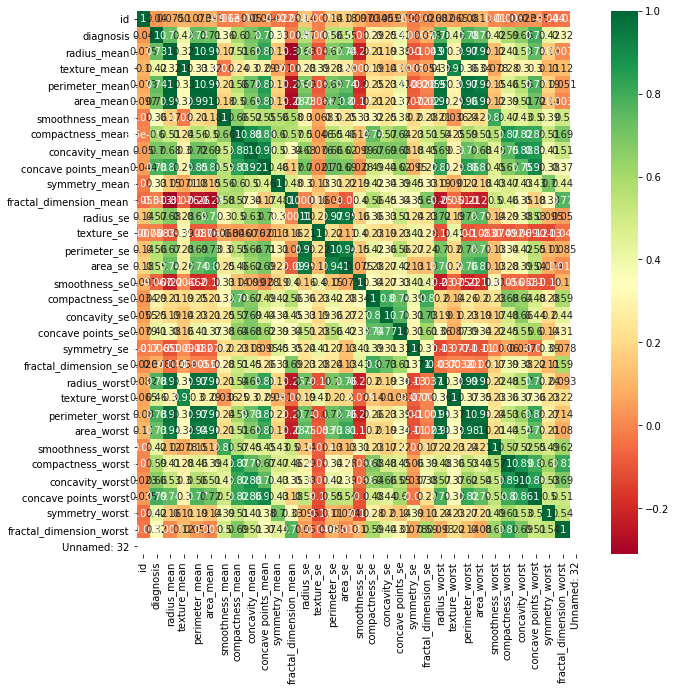

In [15]:
## Correlation
import seaborn as sns

#get correlations of each features in dataset
corrmat = df.corr()
top_corr_features = corrmat.index
plt.figure(figsize=(10,10))
#plot heat map
g=sns.heatmap(df[top_corr_features].corr(),annot=True,cmap="RdYlGn")

In [18]:
##Define the outlier detection methods
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor
from sklearn.svm import OneClassSVM
state = np.random.RandomState(1729)
classifiers = {
    "Isolation Forest":IsolationForest(n_estimators=100, max_samples=len(X), 
                                       contamination=outlier_fraction,random_state=state, verbose=0)
   
}

#"Local Outlier Factor":LocalOutlierFactor(n_neighbors=20, algorithm='auto', 
#                                              leaf_size=30, metric='minkowski',
#                                              p=2, metric_params=None, contamination=outlier_fraction),
#    "Support Vector Machine":OneClassSVM(kernel='rbf', degree=3, gamma=0.1,nu=0.05, 
#                                         max_iter=-1, )

In [19]:
classifiers.items()

dict_items([('Isolation Forest', IsolationForest(behaviour='deprecated', bootstrap=False,
                contamination=0.5938375350140056, max_features=1.0,
                max_samples=569, n_estimators=100, n_jobs=None,
                random_state=RandomState(MT19937) at 0xC9C8158, verbose=0,
                warm_start=False))])

In [20]:
from sklearn.metrics import classification_report, accuracy_score

n_outliers = len(malignant)
for i, (clf_name,clf) in enumerate(classifiers.items()):
    #Fit the data and tag outliers
    if clf_name == "Local Outlier Factor":
        y_pred = clf.fit_predict(X)
        scores_prediction = clf.negative_outlier_factor_
    elif clf_name == "Support Vector Machine":
        clf.fit(X)
        y_pred = clf.predict(X)
    else:    
        clf.fit(X)
        scores_prediction = clf.decision_function(X)
        y_pred = clf.predict(X)
    #Reshape the prediction values to 0 for Valid transactions , 1 for Fraud transactions
    y_pred[y_pred == 1] = 0
    y_pred[y_pred == -1] = 1
    n_errors = (y_pred != y).sum()
    # Run Classification Metrics
    print("{}: {}".format(clf_name,n_errors))
    print("Accuracy Score :")
    print(accuracy_score(y,y_pred))
    print("Classification Report :")
    print(classification_report(y,y_pred))

Isolation Forest: 180
Accuracy Score :
0.6836555360281195
Classification Report :
              precision    recall  f1-score   support

           0       0.88      0.57      0.69       357
           1       0.55      0.87      0.67       212

    accuracy                           0.68       569
   macro avg       0.72      0.72      0.68       569
weighted avg       0.76      0.68      0.69       569



Liu F T, Kai M T, Zhou Z H. Isolation-Based Anomaly Detection. ACM, 2012.

In [21]:
# Create a custom 1-D lens with Isolation Forest
model = ensemble.IsolationForest(random_state=1729)
model.fit(X)
lens1 = model.decision_function(X).reshape((X.shape[0], 1))  # decision_function(self, X) Average anomaly score of X of the base classifiers.

In [22]:
# Create another 1-D lens with L2-norm
mapper = km.KeplerMapper(verbose=0)
lens2 = mapper.fit_transform(X, projection="l2norm")

In [23]:
from sklearn import preprocessing
projection = "l2norm"
print("\n..Projecting data using: %s" % (projection))
X_l2norm =  np.linalg.norm(X, axis=1).reshape((X.shape[0], 1))
scaler = preprocessing.MinMaxScaler()
lens2 = scaler.fit_transform(X_l2norm)


..Projecting data using: l2norm


In [24]:
# Combine both lenses to get a 2-D [Isolation Forest, L^2-Norm] lens
lens = np.c_[lens1, lens2]
lens

array([[-0.05587876,  0.42810257],
       [ 0.05753702,  0.45004959],
       [ 0.06728697,  0.39262707],
       ...,
       [ 0.07690604,  0.24959046],
       [-0.06561871,  0.42004469],
       [-0.01539551,  0.01915261]])

In [25]:
print(lens[df["diagnosis"] == 0].shape)
print(lens[df["diagnosis"] == 1].shape)

(357, 2)
(212, 2)


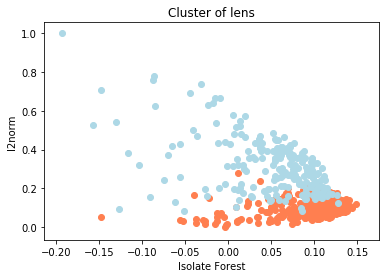

In [67]:
import matplotlib.pyplot as plt

x_Isolate = lens[df["diagnosis"] == 0][:, 0]
y_l2norm = lens[df["diagnosis"] == 0][:, 1]

plt.scatter(x_Isolate, y_l2norm, c='coral')

x_Isolate = lens[df["diagnosis"] == 1][:, 0]
y_l2norm = lens[df["diagnosis"] == 1][:, 1]

plt.scatter(x_Isolate, y_l2norm, c='lightblue')

plt.title('Cluster of lens')
plt.xlabel('Isolate Forest')
plt.ylabel('l2norm')
# plt.savefig('ScatterPlot_05.png')
plt.show()

In [27]:
# Define the simplicial complex
scomplex = mapper.map(lens,
                      X,
                      nr_cubes=15,
                      overlap_perc=0.7,
                      clusterer=sklearn.cluster.KMeans(n_clusters=2,
                                                       random_state=3471))

In [28]:
scomplex.keys()

dict_keys(['nodes', 'links', 'simplices', 'meta_data', 'meta_nodes'])

In [29]:
 # Prefix'ing the data with an ID column
ids = np.array([x for x in range(lens.shape[0])])
lens_ids = np.c_[ids, lens]
from scipy.sparse import issparse
issparse(X)
X_ids = np.c_[ids, X]

In [30]:
print(lens.shape, lens_ids.shape)
print(X.shape, X_ids.shape)

(569, 2) (569, 3)
(569, 31) (569, 32)


Cover

In [31]:
# Cover
# Cover(n_cubes=10, perc_overlap=0.1)
# Cover scheme defines a list of elements
# bins = self.cover.fit(lens_ids)

# TODO: support indexing into any columns
di = np.array(range(1, lens_ids.shape[1]))
indexless_lens_ids = lens_ids[:, di]
n_dims = indexless_lens_ids.shape[1]


In [33]:
 bounds = (np.min(lens, axis=0), np.max(lens, axis=0))
 ranges = bounds[1] - bounds[0]
 print(bounds)
 print(ranges)

(array([-0.19325022,  0.        ]), array([0.14843262, 1.        ]))
[0.34168284 1.        ]


In [34]:
n_cubes = 5
perc_overlap = 0.3

In [35]:
from collections.abc import Iterable

if isinstance(n_cubes, Iterable):
    n_cubes = np.array(n_cubes)
    assert (
        len(n_cubes) == n_dims
        ), "Custom cubes in each dimension must match number of dimensions"
else:
    n_cubes = np.repeat(n_cubes, n_dims)
if isinstance(perc_overlap, Iterable):
    perc_overlap = np.array(perc_overlap)
    assert (
        len(perc_overlap) == n_dims
        ), "Custom cubes in each dimension must match number of dimensions"
else:
    perc_overlap = np.repeat(perc_overlap, n_dims)

assert all(0.0 <= p <= 1.0 for p in perc_overlap), (
    "Each overlap percentage must be between 0.0 and 1.0., not %s"
    % perc_overlap
    )

In [36]:
print(n_cubes, perc_overlap)

[5 5] [0.3 0.3]


In [37]:
inner_range = ((n_cubes - 1) / n_cubes) * ranges
print(inner_range)
inset = (ranges - inner_range) / 2
print(inset)
radius = ranges / (2 * (n_cubes) * (1 - perc_overlap))  # (1 - perc_overlap) * radius = inset (r)
print(radius)

[0.27334627 0.8       ]
[0.03416828 0.1       ]
[0.04881183 0.14285714]


In [38]:
zip_items = list(bounds)
zip_items.extend([n_cubes, inset])
zip_items

[array([-0.19325022,  0.        ]),
 array([0.14843262, 1.        ]),
 array([5, 5]),
 array([0.03416828, 0.1       ])]

In [39]:
print(set(zip(*zip_items)))

{(-0.19325021923497354, 0.14843261588938972, 5, 0.03416828351243631), (0.0, 1.0, 5, 0.09999999999999998)}


In [40]:
centers_per_dimension = [
    np.linspace(b + r, c - r, num=n) for b, c, n, r in zip(*zip_items)
    ]
print(centers_per_dimension)

[array([-0.15908194, -0.09074537, -0.0224088 ,  0.04592777,  0.11426433]), array([0.1, 0.3, 0.5, 0.7, 0.9])]


In [41]:
from itertools import product

centers = [np.array(c) for c in product(*centers_per_dimension)]
centers

[array([-0.15908194,  0.1       ]),
 array([-0.15908194,  0.3       ]),
 array([-0.15908194,  0.5       ]),
 array([-0.15908194,  0.7       ]),
 array([-0.15908194,  0.9       ]),
 array([-0.09074537,  0.1       ]),
 array([-0.09074537,  0.3       ]),
 array([-0.09074537,  0.5       ]),
 array([-0.09074537,  0.7       ]),
 array([-0.09074537,  0.9       ]),
 array([-0.0224088,  0.1      ]),
 array([-0.0224088,  0.3      ]),
 array([-0.0224088,  0.5      ]),
 array([-0.0224088,  0.7      ]),
 array([-0.0224088,  0.9      ]),
 array([0.04592777, 0.1       ]),
 array([0.04592777, 0.3       ]),
 array([0.04592777, 0.5       ]),
 array([0.04592777, 0.7       ]),
 array([0.04592777, 0.9       ]),
 array([0.11426433, 0.1       ]),
 array([0.11426433, 0.3       ]),
 array([0.11426433, 0.5       ]),
 array([0.11426433, 0.7       ]),
 array([0.11426433, 0.9       ])]

In [42]:
list(enumerate(centers))

[(0, array([-0.15908194,  0.1       ])),
 (1, array([-0.15908194,  0.3       ])),
 (2, array([-0.15908194,  0.5       ])),
 (3, array([-0.15908194,  0.7       ])),
 (4, array([-0.15908194,  0.9       ])),
 (5, array([-0.09074537,  0.1       ])),
 (6, array([-0.09074537,  0.3       ])),
 (7, array([-0.09074537,  0.5       ])),
 (8, array([-0.09074537,  0.7       ])),
 (9, array([-0.09074537,  0.9       ])),
 (10, array([-0.0224088,  0.1      ])),
 (11, array([-0.0224088,  0.3      ])),
 (12, array([-0.0224088,  0.5      ])),
 (13, array([-0.0224088,  0.7      ])),
 (14, array([-0.0224088,  0.9      ])),
 (15, array([0.04592777, 0.1       ])),
 (16, array([0.04592777, 0.3       ])),
 (17, array([0.04592777, 0.5       ])),
 (18, array([0.04592777, 0.7       ])),
 (19, array([0.04592777, 0.9       ])),
 (20, array([0.11426433, 0.1       ])),
 (21, array([0.11426433, 0.3       ])),
 (22, array([0.11426433, 0.5       ])),
 (23, array([0.11426433, 0.7       ])),
 (24, array([0.11426433, 0.9  

In [43]:
center_0 = list(enumerate(centers))[0][1]
lowerbounds_0, upperbounds_0 = center_0 - radius, center_0 + radius
print(center_0)
print(radius)
print(lowerbounds_0, upperbounds_0)

[-0.15908194  0.1       ]
[0.04881183 0.14285714]
[-0.20789377 -0.04285714] [-0.1102701   0.24285714]


In [44]:
entries_0 = (lens_ids[:, di] >= lowerbounds_0) & (
    lens_ids[:, di] <= upperbounds_0
)
hypercube_0 = lens_ids[np.invert(np.any(entries_0 == False, axis=1))]
hypercube_0
print(hypercube_0.shape)

(2, 3)


In [45]:
centers

[array([-0.15908194,  0.1       ]),
 array([-0.15908194,  0.3       ]),
 array([-0.15908194,  0.5       ]),
 array([-0.15908194,  0.7       ]),
 array([-0.15908194,  0.9       ]),
 array([-0.09074537,  0.1       ]),
 array([-0.09074537,  0.3       ]),
 array([-0.09074537,  0.5       ]),
 array([-0.09074537,  0.7       ]),
 array([-0.09074537,  0.9       ]),
 array([-0.0224088,  0.1      ]),
 array([-0.0224088,  0.3      ]),
 array([-0.0224088,  0.5      ]),
 array([-0.0224088,  0.7      ]),
 array([-0.0224088,  0.9      ]),
 array([0.04592777, 0.1       ]),
 array([0.04592777, 0.3       ]),
 array([0.04592777, 0.5       ]),
 array([0.04592777, 0.7       ]),
 array([0.04592777, 0.9       ]),
 array([0.11426433, 0.1       ]),
 array([0.11426433, 0.3       ]),
 array([0.11426433, 0.5       ]),
 array([0.11426433, 0.7       ]),
 array([0.11426433, 0.9       ])]

In [46]:
radius
lowerbounds, upperbounds = centers - radius, centers + radius


In [47]:
lowerbounds

array([[-0.20789377, -0.04285714],
       [-0.20789377,  0.15714286],
       [-0.20789377,  0.35714286],
       [-0.20789377,  0.55714286],
       [-0.20789377,  0.75714286],
       [-0.1395572 , -0.04285714],
       [-0.1395572 ,  0.15714286],
       [-0.1395572 ,  0.35714286],
       [-0.1395572 ,  0.55714286],
       [-0.1395572 ,  0.75714286],
       [-0.07122064, -0.04285714],
       [-0.07122064,  0.15714286],
       [-0.07122064,  0.35714286],
       [-0.07122064,  0.55714286],
       [-0.07122064,  0.75714286],
       [-0.00288407, -0.04285714],
       [-0.00288407,  0.15714286],
       [-0.00288407,  0.35714286],
       [-0.00288407,  0.55714286],
       [-0.00288407,  0.75714286],
       [ 0.0654525 , -0.04285714],
       [ 0.0654525 ,  0.15714286],
       [ 0.0654525 ,  0.35714286],
       [ 0.0654525 ,  0.55714286],
       [ 0.0654525 ,  0.75714286]])

In [48]:
upperbounds

array([[-0.1102701 ,  0.24285714],
       [-0.1102701 ,  0.44285714],
       [-0.1102701 ,  0.64285714],
       [-0.1102701 ,  0.84285714],
       [-0.1102701 ,  1.04285714],
       [-0.04193354,  0.24285714],
       [-0.04193354,  0.44285714],
       [-0.04193354,  0.64285714],
       [-0.04193354,  0.84285714],
       [-0.04193354,  1.04285714],
       [ 0.02640303,  0.24285714],
       [ 0.02640303,  0.44285714],
       [ 0.02640303,  0.64285714],
       [ 0.02640303,  0.84285714],
       [ 0.02640303,  1.04285714],
       [ 0.0947396 ,  0.24285714],
       [ 0.0947396 ,  0.44285714],
       [ 0.0947396 ,  0.64285714],
       [ 0.0947396 ,  0.84285714],
       [ 0.0947396 ,  1.04285714],
       [ 0.16307617,  0.24285714],
       [ 0.16307617,  0.44285714],
       [ 0.16307617,  0.64285714],
       [ 0.16307617,  0.84285714],
       [ 0.16307617,  1.04285714]])

In [49]:
ll = 24
entries = (lens_ids[:, di] >= lowerbounds[ll]) & (
    lens_ids[:, di] <= upperbounds[ll]
)
hypercube = lens_ids[np.invert(np.any(entries == False, axis=1))]
hypercube

array([], shape=(0, 3), dtype=float64)

In [50]:
list(enumerate(centers))

[(0, array([-0.15908194,  0.1       ])),
 (1, array([-0.15908194,  0.3       ])),
 (2, array([-0.15908194,  0.5       ])),
 (3, array([-0.15908194,  0.7       ])),
 (4, array([-0.15908194,  0.9       ])),
 (5, array([-0.09074537,  0.1       ])),
 (6, array([-0.09074537,  0.3       ])),
 (7, array([-0.09074537,  0.5       ])),
 (8, array([-0.09074537,  0.7       ])),
 (9, array([-0.09074537,  0.9       ])),
 (10, array([-0.0224088,  0.1      ])),
 (11, array([-0.0224088,  0.3      ])),
 (12, array([-0.0224088,  0.5      ])),
 (13, array([-0.0224088,  0.7      ])),
 (14, array([-0.0224088,  0.9      ])),
 (15, array([0.04592777, 0.1       ])),
 (16, array([0.04592777, 0.3       ])),
 (17, array([0.04592777, 0.5       ])),
 (18, array([0.04592777, 0.7       ])),
 (19, array([0.04592777, 0.9       ])),
 (20, array([0.11426433, 0.1       ])),
 (21, array([0.11426433, 0.3       ])),
 (22, array([0.11426433, 0.5       ])),
 (23, array([0.11426433, 0.7       ])),
 (24, array([0.11426433, 0.9  

In [51]:
def transform_single(data, center, i=0):

        lowerbounds, upperbounds = center - radius, center + radius

        # Slice the hypercube
        entries = (data[:, di] >= lowerbounds) & (
            data[:, di] <= upperbounds
        )
        hypercube = data[np.invert(np.any(entries == False, axis=1))]

        return hypercube

In [52]:
hypercubes = [
    transform_single(lens_ids, cube, i) for i, cube in enumerate(centers)
]

In [53]:
print(list(map(len, hypercubes)))

[2, 1, 3, 1, 1, 6, 7, 6, 4, 1, 40, 27, 20, 8, 0, 144, 125, 53, 2, 0, 343, 129, 15, 0, 0]


In [54]:
hypercubes = [cube for cube in hypercubes if len(cube)]
print(list(map(len, hypercubes)))

[2, 1, 3, 1, 1, 6, 7, 6, 4, 1, 40, 27, 20, 8, 144, 125, 53, 2, 343, 129, 15]


In [57]:
min_cluster_samples = 2
hypercube = hypercubes[5]
print(hypercube)
hypercube.shape[0]>= min_cluster_samples

[[ 3.00000000e+00 -1.27502616e-01  9.60674965e-02]
 [ 9.00000000e+00 -6.13120339e-02  1.31553135e-01]
 [ 6.80000000e+01 -5.63325005e-02  3.71716378e-02]
 [ 7.10000000e+01 -5.25827626e-02  2.97930092e-02]
 [ 1.90000000e+02 -9.09623325e-02  1.57130726e-01]
 [ 3.79000000e+02 -5.12294558e-02  8.26540898e-02]]


True

In [58]:
hypercube[:,0]

array([  3.,   9.,  68.,  71., 190., 379.])

In [59]:
ids = [int(nn) for nn in hypercube[:, 0]]
print(ids)  
X_cube = X[ids]  
X_cube.shape           

[3, 9, 68, 71, 190, 379]


(6, 31)

In [60]:
fit_data = X_cube[:, 1:]
fit_data.shape

(6, 30)

Cluster

In [61]:
from sklearn import cluster
clusterer = sklearn.cluster.KMeans(n_clusters=2, random_state=3471)
cluster_params = clusterer.get_params()
cluster_params

{'algorithm': 'auto',
 'copy_x': True,
 'init': 'k-means++',
 'max_iter': 300,
 'n_clusters': 2,
 'n_init': 10,
 'n_jobs': None,
 'precompute_distances': 'auto',
 'random_state': 3471,
 'tol': 0.0001,
 'verbose': 0}

In [62]:
cluster_predictions = clusterer.fit_predict(fit_data) 
print(cluster_predictions)
print(
    "   > Found %s clusters in hypercube %s."
    % (
        np.unique(
            cluster_predictions[cluster_predictions > -1]
        ).shape[0], 5
    )
)


[0 0 1 1 0 0]
   > Found 2 clusters in hypercube 5.


In [70]:
y[ids]

array([1, 1, 0, 0, 1, 1], dtype=int64)

In [71]:
np.unique(cluster_predictions)

array([0, 1])

In [72]:
from collections import defaultdict

nodes = defaultdict(list)
pred = 0
cluster_id = "cube5_cluster0"
nodes[cluster_id] = hypercube[:, 0][cluster_predictions == pred].astype(int).tolist()
nodes

defaultdict(list, {'cube5_cluster0': [3, 9, 190, 379]})

In [74]:
precomputed = False
nodes = defaultdict(list)
for i, hypercube in enumerate(hypercubes):
    if hypercube.shape[0] >= min_cluster_samples:                
        ids = [int(nn) for nn in hypercube[:, 0]]
        X_cube = X[ids]

        fit_data = X_cube[:, 1:]
        if precomputed:
            fit_data = fit_data[:, ids]

        cluster_predictions = clusterer.fit_predict(fit_data)      
        
        for pred in np.unique(cluster_predictions):                    
            if pred != -1 and not np.isnan(pred):  
                cluster_id = "cube{}_cluster{}".format(i, int(pred))
                        
                nodes[cluster_id] = hypercube[:, 0][cluster_predictions == pred].astype(int).tolist()

In [75]:
from kmapper.kmapper import KeplerMapper

In [76]:
def _remove_duplicate_nodes(nodes):

        # invert node list and merge duplicate nodes
        deduped_items = defaultdict(list)
        for node_id, items in nodes.items():
            deduped_items[frozenset(items)].append(node_id)

        deduped_nodes = {
            "|".join(node_id_list): list(frozen_items)
            for frozen_items, node_id_list in deduped_items.items()
        }

        return deduped_nodes

In [77]:
nodes = _remove_duplicate_nodes(nodes)
print(list(map(len, nodes)))

[14, 14, 14, 14, 14, 14, 14, 29, 14, 14, 14, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15]


In [79]:
import itertools


def compute(nodes, min_intersection=1):
        """Helper function to find edges of the overlapping clusters.

        Parameters
        ----------
        nodes:
            A dictionary with entires `{node id}:{list of ids in node}`

        Returns
        -------
        edges:
            A 1-skeleton of the nerve (intersecting  nodes)

        simplicies: 
            Complete list of simplices

        """

        result = defaultdict(list)

        # Create links when clusters from different hypercubes have members with the same sample id.
        candidates = itertools.combinations(nodes.keys(), 2)     # len(candidates) = from len(nodes.key()) pick 2
        for candidate in candidates:
            # if there are non-unique members in the union
            if (
                len(set(nodes[candidate[0]]).intersection(nodes[candidate[1]]))
                >= min_intersection
            ):
                result[candidate[0]].append(candidate[1])

        edges = [[x, end] for x in result for end in result[x]]
        simplices = [[n] for n in nodes] + edges
        return result, simplices


In [80]:
# Nerve
links, simplices = compute(nodes)
links

defaultdict(list,
            {'cube0_cluster1': ['cube5_cluster0'],
             'cube2_cluster0': ['cube7_cluster1'],
             'cube2_cluster1': ['cube6_cluster1|cube7_cluster0'],
             'cube5_cluster0': ['cube10_cluster0', 'cube10_cluster1'],
             'cube5_cluster1': ['cube10_cluster1'],
             'cube6_cluster0': ['cube11_cluster0'],
             'cube6_cluster1|cube7_cluster0': ['cube11_cluster1',
              'cube12_cluster0'],
             'cube7_cluster1': ['cube8_cluster1'],
             'cube8_cluster1': ['cube13_cluster1'],
             'cube10_cluster0': ['cube11_cluster0',
              'cube14_cluster0',
              'cube14_cluster1',
              'cube15_cluster1'],
             'cube10_cluster1': ['cube14_cluster1'],
             'cube11_cluster0': ['cube14_cluster0',
              'cube15_cluster0',
              'cube15_cluster1'],
             'cube11_cluster1': ['cube12_cluster0',
              'cube15_cluster0',
              'cube16_clust

In [81]:
result = defaultdict(list)
candidates = itertools.combinations(nodes.keys(), 2)
for candidate in candidates:
    if (
        len(set(nodes[candidate[0]]).intersection(nodes[candidate[1]]))
        >= 1
        ):
        result[candidate[0]].append(candidate[1])

In [82]:
result['cube0_cluster1']

['cube5_cluster0']

In [83]:
edges = [[x, end] for x in result for end in result[x]]
edges

[['cube0_cluster1', 'cube5_cluster0'],
 ['cube2_cluster0', 'cube7_cluster1'],
 ['cube2_cluster1', 'cube6_cluster1|cube7_cluster0'],
 ['cube5_cluster0', 'cube10_cluster0'],
 ['cube5_cluster0', 'cube10_cluster1'],
 ['cube5_cluster1', 'cube10_cluster1'],
 ['cube6_cluster0', 'cube11_cluster0'],
 ['cube6_cluster1|cube7_cluster0', 'cube11_cluster1'],
 ['cube6_cluster1|cube7_cluster0', 'cube12_cluster0'],
 ['cube7_cluster1', 'cube8_cluster1'],
 ['cube8_cluster1', 'cube13_cluster1'],
 ['cube10_cluster0', 'cube11_cluster0'],
 ['cube10_cluster0', 'cube14_cluster0'],
 ['cube10_cluster0', 'cube14_cluster1'],
 ['cube10_cluster0', 'cube15_cluster1'],
 ['cube10_cluster1', 'cube14_cluster1'],
 ['cube11_cluster0', 'cube14_cluster0'],
 ['cube11_cluster0', 'cube15_cluster0'],
 ['cube11_cluster0', 'cube15_cluster1'],
 ['cube11_cluster1', 'cube12_cluster0'],
 ['cube11_cluster1', 'cube15_cluster0'],
 ['cube11_cluster1', 'cube16_cluster0'],
 ['cube12_cluster0', 'cube15_cluster0'],
 ['cube12_cluster0', 'cube1

In [84]:
simplices = [[n] for n in nodes] + edges
simplices[1]

['cube0_cluster1']

In [85]:
[[n] for n in nodes]

[['cube0_cluster0'],
 ['cube0_cluster1'],
 ['cube2_cluster0'],
 ['cube2_cluster1'],
 ['cube5_cluster0'],
 ['cube5_cluster1'],
 ['cube6_cluster0'],
 ['cube6_cluster1|cube7_cluster0'],
 ['cube7_cluster1'],
 ['cube8_cluster0'],
 ['cube8_cluster1'],
 ['cube10_cluster0'],
 ['cube10_cluster1'],
 ['cube11_cluster0'],
 ['cube11_cluster1'],
 ['cube12_cluster0'],
 ['cube12_cluster1'],
 ['cube13_cluster0'],
 ['cube13_cluster1'],
 ['cube14_cluster0'],
 ['cube14_cluster1'],
 ['cube15_cluster0'],
 ['cube15_cluster1'],
 ['cube16_cluster0'],
 ['cube16_cluster1'],
 ['cube17_cluster0'],
 ['cube17_cluster1'],
 ['cube18_cluster0'],
 ['cube18_cluster1'],
 ['cube19_cluster0'],
 ['cube19_cluster1'],
 ['cube20_cluster0'],
 ['cube20_cluster1']]

In [86]:
result = defaultdict(list)
set(nodes['cube10_cluster0']).intersection(nodes['cube11_cluster0'])

{15, 38, 138, 203, 257, 259, 290, 351, 430, 562}

In [87]:
scomplex.keys()

dict_keys(['nodes', 'links', 'simplices', 'meta_data', 'meta_nodes'])

In [88]:
scomplex['meta_nodes']

defaultdict(list, {})

In [89]:
scomplex['nodes']['cube15_cluster1']

[108]

In [50]:
scomplex['links'].keys()

dict_keys(['cube5_cluster1', 'cube5_cluster0', 'cube10_cluster1', 'cube10_cluster0', 'cube11_cluster1', 'cube11_cluster0', 'cube13_cluster1', 'cube13_cluster0', 'cube14_cluster1', 'cube14_cluster0', 'cube15_cluster1', 'cube15_cluster0', 'cube16_cluster0', 'cube16_cluster1', 'cube21_cluster1', 'cube21_cluster0', 'cube22_cluster1', 'cube22_cluster0', 'cube25_cluster1', 'cube25_cluster0', 'cube26_cluster1', 'cube26_cluster0', 'cube27_cluster1', 'cube27_cluster0', 'cube28_cluster1', 'cube28_cluster0', 'cube29_cluster1', 'cube29_cluster0', 'cube30_cluster0', 'cube30_cluster1', 'cube33_cluster1', 'cube33_cluster0', 'cube34_cluster0', 'cube34_cluster1', 'cube35_cluster1', 'cube35_cluster0', 'cube36_cluster1', 'cube36_cluster0', 'cube37_cluster1', 'cube37_cluster0', 'cube38_cluster1', 'cube38_cluster0', 'cube39_cluster1', 'cube39_cluster0', 'cube41_cluster1', 'cube41_cluster0', 'cube42_cluster0', 'cube42_cluster1', 'cube43_cluster1', 'cube43_cluster0', 'cube44_cluster1', 'cube45_cluster1', 'cu

In [90]:
pl_brewer = [[0.0, '#006837'],
             [0.1, '#1a9850'],
             [0.2, '#66bd63'],
             [0.3, '#a6d96a'],
             [0.4, '#d9ef8b'],
             [0.5, '#ffffbf'],
             [0.6, '#fee08b'],
             [0.7, '#fdae61'],
             [0.8, '#f46d43'],
             [0.9, '#d73027'],
             [1.0, '#a50026']]

In [91]:
color_function = lens [:,0] - lens[:,0].min()
my_colorscale = pl_brewer

In [92]:
kmgraph,  mapper_summary, colorf_distribution = get_mapper_graph(scomplex)


In [93]:
kmgraph.keys()

dict_keys(['nodes', 'links'])

In [94]:
kmgraph['nodes'][1]

{'id': 1,
 'name': 'cube5_cluster0',
 'member_ids': [212],
 'color': 0.3732394366197183,
 'size': 1,
 'cluster': {'above': [], 'below': [], 'size': 1},
 'distribution': [{'height': 0.0, 'perc': 0.0, 'color': 'rgb(70, 18, 100)'},
  {'height': 0.0, 'perc': 0.0, 'color': 'rgb(68, 51, 125)'},
  {'height': 0.0, 'perc': 0.0, 'color': 'rgb(58, 80, 138)'},
  {'height': 100.0, 'perc': 100.0, 'color': 'rgb(46, 107, 141)'},
  {'height': 0.0, 'perc': 0.0, 'color': 'rgb(36, 131, 141)'},
  {'height': 0.0, 'perc': 0.0, 'color': 'rgb(33, 155, 136)'},
  {'height': 0.0, 'perc': 0.0, 'color': 'rgb(51, 178, 121)'},
  {'height': 0.0, 'perc': 0.0, 'color': 'rgb(94, 199, 96)'},
  {'height': 0.0, 'perc': 0.0, 'color': 'rgb(155, 215, 59)'},
  {'height': 0.0, 'perc': 0.0, 'color': 'rgb(220, 226, 37)'}],
 'projection': [],
 'custom_tooltips': None}

In [95]:
kmgraph['links'][0]

{'source': 0, 'target': 7}

In [96]:
mapper_summary

{'custom_meta': {'projection': 'l2norm',
  'n_cubes': 15,
  'perc_overlap': 0.7,
  'clusterer': "KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,<br>       n_clusters=2, n_init=10, n_jobs=None, precompute_distances='auto',<br>       random_state=3471, tol=0.0001, verbose=0)",
  'scaler': 'MinMaxScaler(copy=True, feature_range=(0, 1))'},
 'n_nodes': 278,
 'n_edges': 2999,
 'n_total': 5673,
 'n_unique': 568}

In [97]:
colorf_distribution

[{'height': 26.0, 'perc': 7.2, 'color': 'rgb(70, 18, 100)'},
 {'height': 32.0, 'perc': 9.0, 'color': 'rgb(68, 51, 125)'},
 {'height': 36.0, 'perc': 10.1, 'color': 'rgb(58, 80, 138)'},
 {'height': 65.0, 'perc': 18.3, 'color': 'rgb(46, 107, 141)'},
 {'height': 100.0, 'perc': 28.1, 'color': 'rgb(36, 131, 141)'},
 {'height': 76.0, 'perc': 21.2, 'color': 'rgb(33, 155, 136)'},
 {'height': 13.0, 'perc': 3.6, 'color': 'rgb(51, 178, 121)'},
 {'height': 6.0, 'perc': 1.8, 'color': 'rgb(94, 199, 96)'},
 {'height': 1.0, 'perc': 0.4, 'color': 'rgb(155, 215, 59)'},
 {'height': 1.0, 'perc': 0.4, 'color': 'rgb(220, 226, 37)'}]

In [98]:

# assign to node['custom_tooltips']  the node label (0 for benign, 1 for malignant)
for node in kmgraph['nodes']:
    node['custom_tooltips'] = y[scomplex['nodes'][node['name']]]                        

In [99]:
kmgraph['nodes'][120]

{'id': 120,
 'name': 'cube81_cluster0',
 'member_ids': [219, 236, 339, 503, 521],
 'color': 0.6401408450704225,
 'size': 2,
 'cluster': {'above': [], 'below': [], 'size': 5},
 'distribution': [{'height': 0.0, 'perc': 0.0, 'color': 'rgb(70, 18, 100)'},
  {'height': 0.0, 'perc': 0.0, 'color': 'rgb(68, 51, 125)'},
  {'height': 0.0, 'perc': 0.0, 'color': 'rgb(58, 80, 138)'},
  {'height': 100.0, 'perc': 20.0, 'color': 'rgb(46, 107, 141)'},
  {'height': 100.0, 'perc': 20.0, 'color': 'rgb(36, 131, 141)'},
  {'height': 100.0, 'perc': 20.0, 'color': 'rgb(33, 155, 136)'},
  {'height': 0.0, 'perc': 0.0, 'color': 'rgb(51, 178, 121)'},
  {'height': 0.0, 'perc': 0.0, 'color': 'rgb(94, 199, 96)'},
  {'height': 100.0, 'perc': 20.0, 'color': 'rgb(155, 215, 59)'},
  {'height': 100.0, 'perc': 20.0, 'color': 'rgb(220, 226, 37)'}],
 'projection': [],
 'custom_tooltips': array([1, 1, 1, 1, 1], dtype=int64)}

In [100]:
print(scomplex['nodes'][kmgraph['nodes'][120]['name']])

[219, 236, 339, 503, 521]


In [101]:
y[scomplex['nodes'][kmgraph['nodes'][120]['name']]]

array([1, 1, 1, 1, 1], dtype=int64)

In [102]:
bgcolor = 'rgba(10,10,10, 0.9)'  # background color
y_gridcolor = 'rgb(150,150,150)'# on a black background the gridlines are set on  grey

In [103]:
plotly_graph_data = plotly_graph(kmgraph, graph_layout='fr', colorscale=my_colorscale, 
                                 factor_size=2.5, edge_linewidth=0.5)

In [104]:
print(len(plotly_graph_data))
print(plotly_graph_data[0].keys())
print(plotly_graph_data[0]['type'])

2
dict_keys(['type', 'x', 'y', 'mode', 'line', 'hoverinfo'])
scatter


In [105]:
colorscale=my_colorscale
colorscale

[[0.0, '#006837'],
 [0.1, '#1a9850'],
 [0.2, '#66bd63'],
 [0.3, '#a6d96a'],
 [0.4, '#d9ef8b'],
 [0.5, '#ffffbf'],
 [0.6, '#fee08b'],
 [0.7, '#fdae61'],
 [0.8, '#f46d43'],
 [0.9, '#d73027'],
 [1.0, '#a50026']]

In [106]:
n_nodes = len(kmgraph["nodes"])
G = ig.Graph(n=n_nodes)
links = [(e["source"], e["target"]) for e in kmgraph["links"]]  # the list of tuples representing the graph edges eg: [(0, 7), (0, 9)]
G.add_edges(links)
graph_layout="kk"
layt = G.layout(graph_layout)   # layt: list of node coordinates assigned by igraph.Layout graph with Kamada-Kawai force-directed algorithm
N = len(layt)                  
Xnodes = [layt[k][0] for k in range(N)]  # x-coordinates of nodes
Ynodes = [layt[k][1] for k in range(N)]  # y-coordnates of nodes
Xedges = []
Yedges = []
for e in links:
    Xedges.extend([layt[e[0]][0], layt[e[1]][0], None])  #adds all the elements of an iterable (list, tuple, string etc.) to the end of the list.
    Yedges.extend([layt[e[0]][1], layt[e[1]][1], None])

In [107]:
hover_text = [node["name"] for node in kmgraph["nodes"]]
color_vals = [node["color"] for node in kmgraph["nodes"]]
factor_size = 2.5
node_size = np.array(
    [factor_size * node["size"] for node in kmgraph["nodes"]], dtype=np.int
    )

In [108]:
edge_linecolor="rgb(180,180,180)"
edge_linewidth=1.5
edge_trace = dict(
        type="scatter",
        x=Xedges,
        y=Yedges,
        mode="lines",
        line=dict(color=edge_linecolor, width=edge_linewidth),
        hoverinfo="none",
    )

node_linecolor="rgb(255,255,255)"
node_linewidth=1.0
colorscale=my_colorscale
showscale=True
node_trace = dict(
        type="scatter",
        x=Xnodes,
        y=Ynodes,
        mode="markers",
        marker=dict(
            size=node_size.tolist(),
            color=color_vals,
            opacity=1.0,
            colorscale=colorscale,
            showscale=showscale,
            line=dict(color=node_linecolor, width=node_linewidth),
            colorbar=dict(thickness=20, ticklen=4, x=1.01, tickfont=dict(size=10)),
        ),
        text=hover_text,
        hoverinfo="text",
    )

In [109]:
def get_kmgraph_meta(mapper_summary):
    """ Extract info from mapper summary to be displayed below the graph plot
    """
    d = mapper_summary["custom_meta"]
    meta = (
        "<b>N_cubes:</b> "
        + str(d["n_cubes"])
        + " <b>Perc_overlap:</b> "
        + str(d["perc_overlap"])
    )
    meta += (
        "<br><b>Nodes:</b> "
        + str(mapper_summary["n_nodes"])
        + " <b>Edges:</b> "
        + str(mapper_summary["n_edges"])
        + " <b>Total samples:</b> "
        + str(mapper_summary["n_total"])
        + " <b>Unique_samples:</b> "
        + str(mapper_summary["n_unique"])
    )

    return meta

In [110]:
annotation_text=get_kmgraph_meta(mapper_summary)
annotation_text

'<b>N_cubes:</b> 15 <b>Perc_overlap:</b> 0.7<br><b>Nodes:</b> 278 <b>Edges:</b> 2999 <b>Total samples:</b> 5673 <b>Unique_samples:</b> 568'

In [111]:
title='Topological network representing the<br>  breast cancer  dataset'
bgcolor = 'rgba(10,10,10, 0.9)'  # background color
width=620
height=570
top=100
left=60
right=60
bottom=60
annotation_text = annotation_text
annotation_x=0
annotation_y=-0.01
pl_layout = dict(
        title=title,
        font=dict(size=12),
        showlegend=False,
        autosize=False,
        width=width,
        height=height,
        xaxis=dict(visible=False),
        yaxis=dict(visible=False),
        hovermode="closest",
        plot_bgcolor=bgcolor,
        margin=dict(t=top, b=bottom, l=left, r=right),
    )
annotations = [
            dict(
                showarrow=False,
                text=annotation_text,
                xref="paper",
                yref="paper",
                x=annotation_x,
                y=annotation_y,
                align="left",
                xanchor="left",
                yanchor="top",
                font=dict(size=12),
            )
        ]
pl_layout.update(annotations=annotations)

In [112]:
pl_layout

{'title': 'Topological network representing the<br>  breast cancer  dataset',
 'font': {'size': 12},
 'showlegend': False,
 'autosize': False,
 'width': 620,
 'height': 570,
 'xaxis': {'visible': False},
 'yaxis': {'visible': False},
 'hovermode': 'closest',
 'plot_bgcolor': 'rgba(10,10,10, 0.9)',
 'margin': {'t': 100, 'b': 60, 'l': 60, 'r': 60},
 'annotations': [{'showarrow': False,
   'text': '<b>N_cubes:</b> 15 <b>Perc_overlap:</b> 0.7<br><b>Nodes:</b> 278 <b>Edges:</b> 2999 <b>Total samples:</b> 5673 <b>Unique_samples:</b> 568',
   'xref': 'paper',
   'yref': 'paper',
   'x': 0,
   'y': -0.01,
   'align': 'left',
   'xanchor': 'left',
   'yanchor': 'top',
   'font': {'size': 12}}]}

In [113]:
plotly_graph_data[0].keys()  # edges

dict_keys(['type', 'x', 'y', 'mode', 'line', 'hoverinfo'])

In [114]:
plotly_graph_data[1].keys()

dict_keys(['type', 'x', 'y', 'mode', 'marker', 'text', 'hoverinfo'])

In [115]:
print(plotly_graph_data[1]['y'])   # Node

[15.489248157014812, 15.253195061955577, -1.790866017236688, 1.7743916518936895, -0.7322918907302095, 1.2869982914720142, 14.536957602504966, 14.777223575462845, 14.511634295521652, 14.982509781149293, 14.996590378044816, 14.38467422377734, 14.541602140020254, 16.113615375836627, -1.5840981604149915, 1.6983626672173964, -0.9616434943728551, 2.264638952383381, 2.3573946338397187, -1.9386294297971902, 2.2349804549863133, -2.083443577189312, -2.2314889923357843, 14.811299332754446, 14.1565992274566, 14.35923450174691, 14.955500940522619, 15.23487667115037, 15.096940632718596, 15.598221742302636, -1.1521074634707744, 2.264754841033292, -0.05897552708146204, -3.1182067371687006, -1.3527104169655666, -3.3601145067569824, 1.7755789836708182, -2.736010251367258, 1.88564518812881, -2.363484400969943, 2.080619599315242, -1.7218465930270048, -2.5405782492010864, 15.407544123672453, 14.289290945632692, 15.392505541179938, 14.439158629698335, 15.711433699323663, 14.817554409213558, 12.6675910004400

In [116]:
fw_graph = go.FigureWidget(data=plotly_graph_data, layout=pl_layout)

In [117]:
fw_graph

FigureWidget({
    'data': [{'hoverinfo': 'none',
              'line': {'color': 'rgb(180,180,180)', 'width':…

In [118]:
fw_hist = node_hist_fig(colorf_distribution, bgcolor=bgcolor,
                        y_gridcolor=y_gridcolor)

In [119]:
fw_hist

FigureWidget({
    'data': [{'hoverinfo': 'y+text',
              'marker': {'color': [rgb(70, 18, 100), rgb(6…

In [ ]:
colorf_distribution      # From get_mapper_graph(scomplex)
bgcolor = 'rgba(10,10,10, 0.9)'  # background color
y_gridcolor = 'rgb(150,150,150)'# on a black background the gridlines are set on  grey

In [112]:
colorf_distribution    # 

[{'height': 26.0, 'perc': 7.2, 'color': 'rgb(70, 18, 100)'},
 {'height': 32.0, 'perc': 9.0, 'color': 'rgb(68, 51, 125)'},
 {'height': 36.0, 'perc': 10.1, 'color': 'rgb(58, 80, 138)'},
 {'height': 65.0, 'perc': 18.3, 'color': 'rgb(46, 107, 141)'},
 {'height': 100.0, 'perc': 28.1, 'color': 'rgb(36, 131, 141)'},
 {'height': 76.0, 'perc': 21.2, 'color': 'rgb(33, 155, 136)'},
 {'height': 13.0, 'perc': 3.6, 'color': 'rgb(51, 178, 121)'},
 {'height': 6.0, 'perc': 1.8, 'color': 'rgb(94, 199, 96)'},
 {'height': 1.0, 'perc': 0.4, 'color': 'rgb(155, 215, 59)'},
 {'height': 1.0, 'perc': 0.4, 'color': 'rgb(220, 226, 37)'}]

In [115]:
text = [
        "{perc}%".format(**locals())                  
        for perc in [d["perc"] for d in colorf_distribution]
    ]
text

['7.2%',
 '9.0%',
 '10.1%',
 '18.3%',
 '28.1%',
 '21.2%',
 '3.6%',
 '1.8%',
 '0.4%',
 '0.4%']

"locals" is a function, which returns a dictionary with the current scope's local variables, i.e- the local variable names are the keys of this dictionary and the corresponding values are the values of these variables.
The dictionary returned by locals() can be used as a parameter of the string format method. This way we can use all the local variable names inside of a format string.

In [129]:
pl_hist = go.Bar(
        y=[d["height"] for d in colorf_distribution],
        marker=dict(color=[d["color"] for d in colorf_distribution]),
        text=text,
        hoverinfo="y+text",
    )
pl_hist

Bar({
    'hoverinfo': 'y+text',
    'marker': {'color': [rgb(70, 18, 100), rgb(68, 51, 125), rgb(58, 80, 138),
                         rgb(46, 107, 141), rgb(36, 131, 141), rgb(33, 155, 136),
                         rgb(51, 178, 121), rgb(94, 199, 96), rgb(155, 215, 59),
                         rgb(220, 226, 37)]},
    'text': [7.2%, 9.0%, 10.1%, 18.3%, 28.1%, 21.2%, 3.6%, 1.8%, 0.4%, 0.4%],
    'y': [26.0, 32.0, 36.0, 65.0, 100.0, 76.0, 13.0, 6.0, 1.0, 1.0]
})

The bar plot can be customized using keyword arguments.

In [132]:
hist_title="Graph Node Distribution"
hist_width=400
hist_height=300
hist_top=60
hist_left=25
hist_bottom=60
hist_right=25
hist_bgcolor="rgb(240,240,240)"
hist_y_gridcolor="white"

In [133]:
 hist_layout = dict(
        title=hist_title,
        width=hist_width,
        height=hist_height,
        font=dict(size=12),
        xaxis=dict(showline=True, zeroline=False, showgrid=False, showticklabels=False),
        yaxis=dict(showline=False, gridcolor=hist_y_gridcolor, tickfont=dict(size=10)),
        bargap=0.01,
        margin=dict(l=hist_left, r=hist_right, b=hist_bottom, t=hist_top),
        hovermode="x",
        plot_bgcolor=hist_bgcolor,
    )

In [134]:
go.FigureWidget(data=[pl_hist], layout=hist_layout)

FigureWidget({
    'data': [{'hoverinfo': 'y+text',
              'marker': {'color': [rgb(70, 18, 100), rgb(6…

In [135]:
fw_summary = summary_fig(mapper_summary, height=300)
fw_summary

FigureWidget({
    'data': [{'hoverinfo': 'none',
              'mode': 'text',
              'text': [<br><b>…

In [136]:
VBox([fw_graph, HBox([fw_summary, fw_hist])])

    'data': [{'hoverinfo': 'none',
              'line': {'color': 'rgb(180,180,…

In [137]:
dashboard = hovering_widgets(kmgraph, 
                             fw_graph, 
                             ctooltips=True, # ctooltips = True, because we assigned a label to each 
                                             #cluster member
                             bgcolor=bgcolor,
                             y_gridcolor=y_gridcolor, 
                             member_textbox_width=600)
dashboard

    'data': [{'hoverinfo': 'none',
              'line': {'color'…

In [139]:
kmgraph.keys()

dict_keys(['nodes', 'links'])

In [140]:
fw_graph

FigureWidget({
    'data': [{'hoverinfo': 'none',
              'line': {'color': 'rgb(180,180,180)', 'width':…

In [252]:
fnode = kmgraph["nodes"][120]
fnode

{'id': 120,
 'name': 'cube81_cluster0',
 'member_ids': [219, 236, 339, 503, 521],
 'color': 0.6401408450704225,
 'size': 2,
 'cluster': {'above': [], 'below': [], 'size': 5},
 'distribution': [{'height': 0.0, 'perc': 0.0, 'color': 'rgb(70, 18, 100)'},
  {'height': 0.0, 'perc': 0.0, 'color': 'rgb(68, 51, 125)'},
  {'height': 0.0, 'perc': 0.0, 'color': 'rgb(58, 80, 138)'},
  {'height': 100.0, 'perc': 20.0, 'color': 'rgb(46, 107, 141)'},
  {'height': 100.0, 'perc': 20.0, 'color': 'rgb(36, 131, 141)'},
  {'height': 100.0, 'perc': 20.0, 'color': 'rgb(33, 155, 136)'},
  {'height': 0.0, 'perc': 0.0, 'color': 'rgb(51, 178, 121)'},
  {'height': 0.0, 'perc': 0.0, 'color': 'rgb(94, 199, 96)'},
  {'height': 100.0, 'perc': 20.0, 'color': 'rgb(155, 215, 59)'},
  {'height': 100.0, 'perc': 20.0, 'color': 'rgb(220, 226, 37)'}],
 'projection': [],
 'custom_tooltips': array([1, 1, 1, 1, 1], dtype=int64)}

In [250]:
fwc = node_hist_fig(
        fnode["distribution"],
        title="Cluster Member Distribution",
        width=400,
        height=300,
        top=100,
        left=50,
        bgcolor="rgb(240,240,240)",
        y_gridcolor="white",
    )
fwc

FigureWidget({
    'data': [{'hoverinfo': 'y+text',
              'marker': {'color': [rgb(70, 18, 100), rgb(6…

In [251]:
fwc_text = [
        "{perc}%".format(**locals())
        for perc in [d["perc"] for d in fnode["distribution"]]
    ]
fwc_text

['0.0%',
 '0.0%',
 '0.0%',
 '20.0%',
 '20.0%',
 '20.0%',
 '0.0%',
 '0.0%',
 '20.0%',
 '20.0%']

In [146]:
fwc_pl_hist = go.Bar(
        y=[d["height"] for d in fnode["distribution"]],
        marker=dict(color=[d["color"] for d in fnode["distribution"]]),
        text=fwc_text,
        hoverinfo="y+text",
    )
fwc_pl_hist

Bar({
    'hoverinfo': 'y+text',
    'marker': {'color': [rgb(70, 18, 100), rgb(68, 51, 125), rgb(58, 80, 138),
                         rgb(46, 107, 141), rgb(36, 131, 141), rgb(33, 155, 136),
                         rgb(51, 178, 121), rgb(94, 199, 96), rgb(155, 215, 59),
                         rgb(220, 226, 37)]},
    'text': [0.0%, 0.0%, 100.0%, 0.0%, 0.0%, 0.0%, 0.0%, 0.0%, 0.0%, 0.0%],
    'y': [0.0, 0.0, 100.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
})

In [156]:
fwc_hist_layout = dict(
        title="Cluster Member Distribution",
        width=400,
        height=300,
        font=dict(size=12),
        xaxis=dict(showline=True, zeroline=False, showgrid=False, showticklabels=False),
        yaxis=dict(showline=False, gridcolor=y_gridcolor, tickfont=dict(size=10)),
        bargap=0.01,
        margin=dict(l=50, r=100, b=10, t=100),
        hovermode="x",
        plot_bgcolor=bgcolor,
    )

In [157]:
go.FigureWidget(data=[fwc_pl_hist], layout=fwc_hist_layout)

FigureWidget({
    'data': [{'hoverinfo': 'y+text',
              'marker': {'color': [rgb(70, 18, 100), rgb(6…

In [270]:
clust_textbox = ipw.Text(                                  # ipw: jupyter-widgets ipywidgets
        value="{:d}".format(fnode["cluster"]["size"]),     # format_spec, which is preceded by a colon ':', {:d} d prints as decimal integer
        description="Cluster size:",
        disabled=False,
        continuous_update=True,
    )
clust_textbox

Text(value='5', description='Cluster size:')

In [205]:
clust_textbox.layout = dict(margin="10px 10px 10px 10px", width="200px")

In [174]:
clust_textbox

Text(value='1', description='Cluster size:', layout=Layout(margin='10px 10px 10px 10px', width='200px'))

In [213]:
ctooltips=True  # ctooltips = True, because we assigned a label to each cluster member, ctooltips = False Show member_ids
member_textbox = ipw.Textarea(
        value=", ".join(str(x) for x in fnode["member_ids"])
        if not ctooltips
        else ", ".join(str(x) for x in fnode["custom_tooltips"]),
        description="Members:",
        disabled=False,
        continuous_update=True,
    )
member_textbox

Textarea(value='1', description='Members:')

In [218]:
member_textbox_width=200
member_textbox.layout = dict(
        margin="5px 5px 5px 10px", width=str(member_textbox_width) + "px"
    )
member_textbox

Textarea(value='1', description='Members:', layout=Layout(margin='5px 5px 5px 10px', width='200px'))

In [219]:
def do_on_hover(trace, points, state):
        if not points.point_inds:
            return
        ind = points.point_inds[0]  # get the index of the hovered node
        node = kmgraph["nodes"][ind]
        # on hover do:
        with fwc.batch_update():  # update data in the cluster member histogr
            fwc.data[0].text = [
                "{:.1f}%".format(d["perc"]) for d in node["distribution"]
            ]
            fwc.data[0].y = [d["height"] for d in node["distribution"]]
            fwc.data[0].marker.color = [d["color"] for d in node["distribution"]]

        clust_textbox.value = "{:d}".format(node["cluster"]["size"])
        member_textbox.value = (
            ", ".join(str(x) for x in node["member_ids"])
            if not ctooltips
            else ", ".join(str(x) for x in node["custom_tooltips"])
        )

In [269]:
fwc.data[0]



Bar({
    'hoverinfo': 'y+text',
    'marker': {'color': [rgb(70, 18, 100), rgb(68, 51, 125), rgb(58, 80, 138),
                         rgb(46, 107, 141), rgb(36, 131, 141), rgb(33, 155, 136),
                         rgb(51, 178, 121), rgb(94, 199, 96), rgb(155, 215, 59),
                         rgb(220, 226, 37)]},
    'text': [0.0%, 0.0%, 0.0%, 20.0%, 20.0%, 20.0%, 0.0%, 0.0%, 20.0%, 20.0%],
    'uid': 'ef5de440-1db4-464d-bed3-b0f2e62d8107',
    'y': [0.0, 0.0, 0.0, 100.0, 100.0, 100.0, 0.0, 0.0, 100.0, 100.0]
})

In [240]:
fw_graph.data[1]

Scatter({
    'hoverinfo': 'text',
    'marker': {'color': [0.2147887323943662, 0.3732394366197183,
                         0.00528169014084507, ..., 0.38128772635814895,
                         0.2785211267605634, 0.6382042253521127],
               'colorbar': {'thickness': 20, 'tickfont': {'size': 10}, 'ticklen': 4, 'x': 1.01},
               'colorscale': [[0.0, '#006837'], [0.1, '#1a9850'], [0.2,
                              '#66bd63'], [0.3, '#a6d96a'], [0.4, '#d9ef8b'], [0.5,
                              '#ffffbf'], [0.6, '#fee08b'], [0.7, '#fdae61'], [0.8,
                              '#f46d43'], [0.9, '#d73027'], [1.0, '#a50026']],
               'line': {'color': 'rgb(255,255,255)', 'width': 1.0},
               'opacity': 1.0,
               'showscale': True,
               'size': [2, 2, 2, ..., 7, 5, 5]},
    'mode': 'markers',
    'text': [cube5_cluster1, cube5_cluster0, cube10_cluster1, ...,
             cube163_cluster0, cube164_cluster0, cube164_cluster1],
    'u

In [239]:
trace.on_hover(do_on_hover) 
trace

Scatter({
    'hoverinfo': 'text',
    'marker': {'color': [0.2147887323943662, 0.3732394366197183,
                         0.00528169014084507, ..., 0.38128772635814895,
                         0.2785211267605634, 0.6382042253521127],
               'colorbar': {'thickness': 20, 'tickfont': {'size': 10}, 'ticklen': 4, 'x': 1.01},
               'colorscale': [[0.0, '#006837'], [0.1, '#1a9850'], [0.2,
                              '#66bd63'], [0.3, '#a6d96a'], [0.4, '#d9ef8b'], [0.5,
                              '#ffffbf'], [0.6, '#fee08b'], [0.7, '#fdae61'], [0.8,
                              '#f46d43'], [0.9, '#d73027'], [1.0, '#a50026']],
               'line': {'color': 'rgb(255,255,255)', 'width': 1.0},
               'opacity': 1.0,
               'showscale': True,
               'size': [2, 2, 2, ..., 7, 5, 5]},
    'mode': 'markers',
    'text': [cube5_cluster1, cube5_cluster0, cube10_cluster1, ...,
             cube163_cluster0, cube164_cluster0, cube164_cluster1],
    'u

In [171]:
fw_graph.data[1].marker.colorbar.title = 'dist to<br>x-min'

'1000000'

In [274]:
fw_graph.data[1].marker.colorbar.title

scatter.marker.colorbar.Title()

In [275]:
breastc_dict = {0: 'benign', 1: 'malignant'}

In [283]:
tooltips = list(fw_graph.data[1].text) 

In [284]:
new_color = []

In [278]:
fw_graph

FigureWidget({
    'data': [{'hoverinfo': 'none',
              'line': {'color': 'rgb(180,180,180)', 'width':…

In [314]:
kmgraph['nodes'][128]

{'id': 128,
 'name': 'cube86_cluster0',
 'member_ids': [14, 15, 38, 112, 138, 257, 290, 351, 562],
 'color': 0.3476134585289515,
 'size': 3,
 'cluster': {'above': [], 'below': [], 'size': 9},
 'distribution': [{'height': 100.0, 'perc': 33.3, 'color': 'rgb(70, 18, 100)'},
  {'height': 33.0, 'perc': 11.1, 'color': 'rgb(68, 51, 125)'},
  {'height': 33.0, 'perc': 11.1, 'color': 'rgb(58, 80, 138)'},
  {'height': 0.0, 'perc': 0.0, 'color': 'rgb(46, 107, 141)'},
  {'height': 33.0, 'perc': 11.1, 'color': 'rgb(36, 131, 141)'},
  {'height': 33.0, 'perc': 11.1, 'color': 'rgb(33, 155, 136)'},
  {'height': 33.0, 'perc': 11.1, 'color': 'rgb(51, 178, 121)'},
  {'height': 0.0, 'perc': 0.0, 'color': 'rgb(94, 199, 96)'},
  {'height': 0.0, 'perc': 0.0, 'color': 'rgb(155, 215, 59)'},
  {'height': 33.0, 'perc': 11.1, 'color': 'rgb(220, 226, 37)'}],
 'projection': [],
 'custom_tooltips': array([1, 1, 1, 0, 1, 1, 0, 1, 1], dtype=int64)}

In [316]:
node_128 = [[j, node120] for j, node120 in enumerate(kmgraph['nodes'])][128]

In [317]:
node_128

[128,
 {'id': 128,
  'name': 'cube86_cluster0',
  'member_ids': [14, 15, 38, 112, 138, 257, 290, 351, 562],
  'color': 0.3476134585289515,
  'size': 3,
  'cluster': {'above': [], 'below': [], 'size': 9},
  'distribution': [{'height': 100.0,
    'perc': 33.3,
    'color': 'rgb(70, 18, 100)'},
   {'height': 33.0, 'perc': 11.1, 'color': 'rgb(68, 51, 125)'},
   {'height': 33.0, 'perc': 11.1, 'color': 'rgb(58, 80, 138)'},
   {'height': 0.0, 'perc': 0.0, 'color': 'rgb(46, 107, 141)'},
   {'height': 33.0, 'perc': 11.1, 'color': 'rgb(36, 131, 141)'},
   {'height': 33.0, 'perc': 11.1, 'color': 'rgb(33, 155, 136)'},
   {'height': 33.0, 'perc': 11.1, 'color': 'rgb(51, 178, 121)'},
   {'height': 0.0, 'perc': 0.0, 'color': 'rgb(94, 199, 96)'},
   {'height': 0.0, 'perc': 0.0, 'color': 'rgb(155, 215, 59)'},
   {'height': 33.0, 'perc': 11.1, 'color': 'rgb(220, 226, 37)'}],
  'projection': [],
  'custom_tooltips': array([1, 1, 1, 0, 1, 1, 0, 1, 1], dtype=int64)}]

In [318]:
node_128[1]['name']
member_label_ids = y[scomplex['nodes'][node_128[1]['name']]]

In [319]:
breastc_dict = {0: 'benign', 1: 'malignant'}
member_labels = [breastc_dict[id] for id in member_label_ids]
member_labels

['malignant',
 'malignant',
 'malignant',
 'benign',
 'malignant',
 'malignant',
 'benign',
 'malignant',
 'malignant']

In [323]:
label_type, label_counts = np.unique(member_labels, return_counts=True) 
print(label_type)
print(label_counts)

['benign' 'malignant']
[2 7]


In [327]:
n_members = label_counts.sum()
print(label_counts)
print(n_members)


[2 7]
9


In [330]:
label_type.shape[0]

2

In [331]:
1.0*label_counts[1]/n_members

0.7777777777777778

In [332]:
for m in range(len(label_counts)):
        tooltips[j] += '<br>' + str(label_type[m]) + ': ' + str(label_counts[m]) # append  how many benign/malign 
                                                                                 # members exist in each node

0.7777777777777778

In [336]:
list(range(len(label_counts)))

[0, 1]

In [337]:
str(label_type[0])

'benign'

In [338]:
str(label_counts[0])

'2'

In [339]:
tooltips[128]

'cube86_cluster0'

In [341]:
fwn_graph = go.FigureWidget(fw_graph)
fwn_graph

FigureWidget({
    'data': [{'hoverinfo': 'none',
              'line': {'color': 'rgb(180,180,180)', 'width':…

In [ ]:
fwn_graph = go.FigureWidget(fw_graph) # copy the initial FigureWidget

with fwn_graph.batch_update(): # make updates for the new figure                                                                
    fwn_graph.data[1].text = tooltips # add the new tooltips
    fwn_graph.data[1].marker.colorbar.x = -0.14 # place toolbar at the figure left side
    fwn_graph.layout.width = 550 # change the figure size in order to plot two "parallel" copies
    fwn_graph.layout.height = 550
    fwn_graph.layout.margin.r = 45 # decrease the right margin from 60px (default val) to 45 pixels
    
fw1 = go.FigureWidget(fwn_graph) # define a new figure from  the fwn_graph that will be colored by the new color function  
with fw1.batch_update():
    fw1.data[1].marker.color = new_color # update node colors
    fw1.data[0].line.color = 'rgb(125,125,125)' # update the graph edge color
    fw1.layout.plot_bgcolor = 'rgb(240,240,240)'
    fw1.layout.annotations = None # remove the mapper_summary from the second plot
    fw1.data[1].marker.showscale = False # remove the colorbar
    fw1.layout.title = "Nodes are colored according to the proportion<br> of malignant members"

In [361]:
with fwn_graph.batch_update(): # make updates for the new figure                                                                
    fwn_graph.data[1].text = tooltips # add the new tooltips
    fwn_graph.data[1].marker.colorbar.x = -0.14 # place toolbar at the figure left side
    fwn_graph.layout.width = 550 # change the figure size in order to plot two "parallel" copies
    fwn_graph.layout.height = 550
    fwn_graph.layout.margin.r = 45 # decrease the right margin from 60px (default val) to 45 pixels

In [362]:
fw1 = go.FigureWidget(fwn_graph)

In [363]:
fw1.batch_update()

In [369]:
fw1.data[1].marker.color = new_color

In [ ]:
 cluster_data = {"above": [], "below": [], "size": len(member_ids)}
for s, f, i, c, a, v in above_stats[:5]:
    cluster_data['above'].append({"feature":f, "mean":round(c, 3), "std": round(s,1)})
print(cluster_data)    

In [ ]:
cluster_data

In [ ]:
colorscale

In [ ]:
my_colorscale

In [ ]:
pl_brewer = [[0.0, '#006837'],
             [0.1, '#1a9850'],
             [0.2, '#66bd63'],
             [0.3, '#a6d96a'],
             [0.4, '#d9ef8b'],
             [0.5, '#ffffbf'],
             [0.6, '#fee08b'],
             [0.7, '#fdae61'],
             [0.8, '#f46d43'],
             [0.9, '#d73027'],
             [1.0, '#a50026']]

In [ ]:
my_colorscale = pl_brewer

In [ ]:
my_colorscale[0][1][0]

In [ ]:
type(my_colorscale)

In [ ]:
plotly_colors = np.array(my_colorscale)[:,1].tolist()

In [ ]:
list(enumerate(plotly_colors))

In [ ]:
for k, hexcode in enumerate(plotly_colors):
    hexcode = hexcode.lstrip("#")
    hex_len = len(hexcode)
    step = hex_len // 3
    
   
    

In [ ]:
list(range(0, hex_len, step))

In [ ]:
int(hexcode[4:4+step], 16)

In [ ]:
color_function[member_ids]

In [ ]:
from kmapper.visuals import _colors_to_rgb
my_colorscale = _colors_to_rgb(my_colorscale)
my_colorscale

In [ ]:
member_histogram = build_histogram(
        color_function[member_ids], colorscale=my_colorscale, nbins=10
    )
member_histogram

In [ ]:
hist, bin_edges = np.histogram(color_function[member_ids], range=(0, 1), bins=10)

In [ ]:
hist

In [ ]:
bin_edges

In [ ]:
color_function[member_ids]

In [ ]:
bin_mids = np.mean(np.array(list(zip(bin_edges, bin_edges[1:]))),axis=1)
bin_mids

In [ ]:
histogram = []
max_bucket_value = max(hist)
print(max_bucket_value)
sum_bucket_value = sum(hist)
print(sum_bucket_value)

In [ ]:
list(zip(hist, bin_mids))

In [ ]:
for bar, mid in zip(hist, bin_mids):
    height = np.floor(((bar/max_bucket_value)*100)+0.5)
    perc = round((bar/sum_bucket_value)*100.0,1)
    color = 
    print(height)
    print(perc)

In [ ]:
color = _map_val2color(mid, 0.0, 1.0, colorscale)

In [ ]:
not None

In [ ]:
True and False